Downloading...
From: https://drive.google.com/u/0/uc?id=1ptEVU0cZgkRT6l3wKz9iPmgnxMlZnCCY&export=download
To: /content/all-videos.zip
100%|██████████| 60.0M/60.0M [00:00<00:00, 61.5MB/s]


Archive:  all-videos.zip
   creating: all-videos/ArmFlapping/
  inflating: all-videos/ArmFlapping/ArmFlapping_1.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_10.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_11.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_12.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_13.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_14.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_15.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_16.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_17.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_18.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_19.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_2.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_20.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_21.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_22.mp4  
  inflating: all-videos/ArmFlapping/ArmFlapping_23.mp4  
  inflating: all-videos/ArmF

  saving_api.save_model(



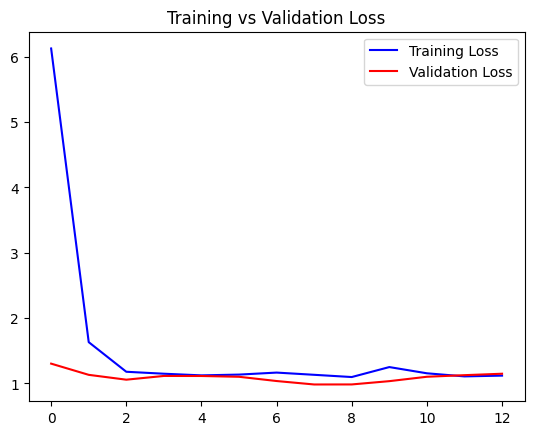

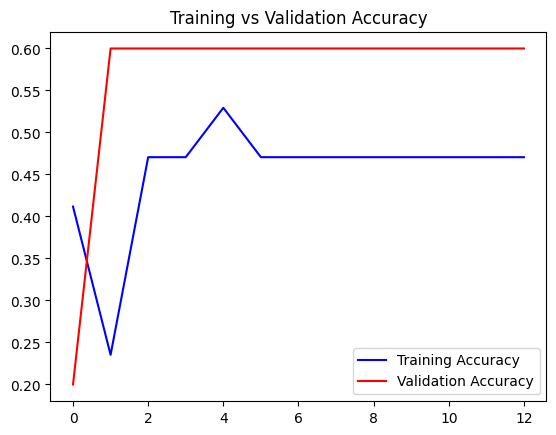

In [ ]:
import os
import cv2
import math
import time
import gdown
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

SEED_CONSTANT = 0
np.random.seed(SEED_CONSTANT)
random.seed(SEED_CONSTANT)
tf.random.set_seed(SEED_CONSTANT)


DATASET = 'all-videos'              # Name of the dataset folder
DATASET_ZIP = DATASET + '.zip'      # Name of the dataset zip file

# If there are no zip files or dataset folders, download the dataset zip file
if not os.path.exists(f'./{DATASET}') and not os.path.exists(f'./{DATASET_ZIP}'):
    download_link = 'https://drive.google.com/u/0/uc?id=1ptEVU0cZgkRT6l3wKz9iPmgnxMlZnCCY&export=download'
    gdown.download(download_link, DATASET_ZIP, quiet=False)

# If there is no dataset folder, unzip the dataset zip file
if not os.path.exists(f'./{DATASET}'):
    !unzip $DATASET_ZIP

# Height and width of resized frames
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128

# Number of frames per video
SEQUENCE_LENGTH = 60

# Number of behaviors under observation
CLASSES_LIST = ["ArmFlapping", "HeadBanging", "Spinning"]


def frames_extraction(video_path, class_name, file_index):
    # contains all the frames
    frames_list = []

    # Read the video
    video_reader = cv2.VideoCapture(video_path)

    # Count the number of frames in the video, this will help us determine the skip size
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the skip size
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        # Sets the target frame of the video
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reads the target frame
        success, frame = video_reader.read()

        if not success:
            break

        '''
        DATA PREPROCESSING
        '''
        # 1. Resizing the frames to get uniform data shape for all frames
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        if file_index == 0 and frame_counter == 0:
            frame_image = tf.image.convert_image_dtype(frame, dtype=tf.uint8)
            png_image = tf.image.encode_png(frame_image)
            png_image_path = class_name + '_first_frame.png'
            with tf.io.gfile.GFile(png_image_path, 'wb') as f:
                f.write(png_image.numpy())
            resized_frame_image = tf.image.convert_image_dtype(resized_frame, dtype=tf.uint8)
            png_image = tf.image.encode_png(resized_frame_image)
            png_image_path = class_name + '_first_resized_frame.png'
            with tf.io.gfile.GFile(png_image_path, 'wb') as f:
                f.write(png_image.numpy())

        # 2. Normalizing the frame data
        normalized_frame = resized_frame / 255

        frames_list.append(normalized_frame)

    video_reader.release()

    return frames_list

# From the extracted dataset, this will create a processed data set for training and evaluation
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET, class_name))

        # Loop through all the videos for each class
        for file_index, file_name in enumerate(files_list):
            video_file_path = os.path.join(DATASET, class_name, file_name)

            # Extract the frames of the video
            frames = frames_extraction(video_file_path, class_name, file_index)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index) # Maps the behavior classes by their index in the CLASSES_LIST
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

features, labels, video_files_paths = create_dataset()
# Implements one hot encoding
one_hot_encoded_labels = to_categorical(labels)
features_train, features_test, labels_train, labels_test = train_test_split(
    features, one_hot_encoded_labels, test_size = 0.25,
    shuffle = True, random_state = SEED_CONSTANT
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout

# 在模型中添加更多的卷积层和正则化
def create_conv3d():
    input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    model = Sequential()

    model.add(Conv3D(16, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape,
                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu',
                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu',
                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

conv3d_model = create_conv3d()
conv3d_model.summary()





print("Model Created Successfully!")

plot_model(
    conv3d_model, to_file = 'conv3d_model_structure_plot.png',
    show_shapes = True, show_layer_names = True
)



conv3d_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'Adam',
    metrics = ["accuracy"]
)


# 调整训练参数
conv3d_model_training_history = conv3d_model.fit(
    x = features_train,
    y = labels_train,
    epochs = 25,  # 增加训练周期
    batch_size = 8,  # 调整批大小
    shuffle = True,
    validation_split = 0.2,  # 调整验证集比例
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]  # 添加早停以避免过拟合
)

model_evaluation_history = conv3d_model.evaluate(features_test, labels_test)

def plot_loss(model_training_history, plot_name):
    '''
    This function will plot the loss metrics in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation loss values at successive epochs.
        plot_name: The title of the graph.
    '''
    # Get loss values.
    loss = model_training_history.history['loss']
    val_loss = model_training_history.history['val_loss']

    # Construct a range object for x-axis.
    epochs = range(len(loss))

    # Plot the Graph.
    plt.figure()  # Create a new figure
    plt.plot(epochs, loss, 'blue', label='Training Loss')
    plt.plot(epochs, val_loss, 'red', label='Validation Loss')

    # Add title and legend to the plot.
    plt.title(plot_name)
    plt.legend()

def plot_accuracy(model_training_history, plot_name):
    '''
    This function will plot the accuracy metrics in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation accuracy values at successive epochs.
        plot_name: The title of the graph.
    '''
    # Get accuracy values.
    accuracy = model_training_history.history['accuracy']
    val_accuracy = model_training_history.history['val_accuracy']

    # Construct a range object for x-axis.
    epochs = range(len(accuracy))

    # Plot the Graph.
    plt.figure()  # Create a new figure
    plt.plot(epochs, accuracy, 'blue', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'red', label='Validation Accuracy')

    # Add title and legend to the plot.
    plt.title(plot_name)
    plt.legend()

# Visualize the training and validation loss.
plot_loss(conv3d_model_training_history, 'Training vs Validation Loss')

# Visualize the training and validation accuracy.
plot_accuracy(conv3d_model_training_history, 'Training vs Validation Accuracy')

# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
conv3d_model.save(model_file_name)

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import clone_model

def cross_validate_model(model, X, y, folds=5):
    kf = KFold(n_splits=folds, shuffle=True, random_state=SEED_CONSTANT)
    fold_accuracies = []

    for train_index, test_index in kf.split(X):
        # Clone the model to avoid incremental training
        cloned_model = clone_model(model)
        cloned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Split the data into training and testing sets
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        # Train the cloned model
        cloned_model.fit(X_train_fold, y_train_fold, batch_size=4, epochs=10, verbose=0)

        # Evaluate the model on the test set
        scores = cloned_model.evaluate(X_test_fold, y_test_fold, verbose=0)
        fold_accuracies.append(scores[1] * 100)

        # Clear the session to free memory after each fold
        tf.keras.backend.clear_session()

    return fold_accuracies

# 5-fold cross-validation
fold_accuracies_5 = cross_validate_model(conv3d_model, features, one_hot_encoded_labels, folds=5)

# 10-fold cross-validation
fold_accuracies_10 = cross_validate_model(conv3d_model, features, one_hot_encoded_labels, folds=10)

# Calculate mean and standard deviation for 5-fold and 10-fold
mean_accuracy_5_fold = np.mean(fold_accuracies_5)
std_accuracy_5_fold = np.std(fold_accuracies_5)
mean_accuracy_10_fold = np.mean(fold_accuracies_10)
std_accuracy_10_fold = np.std(fold_accuracies_10)

print(f'5-fold CV Accuracy: {mean_accuracy_5_fold:.2f}% (sd:{std_accuracy_5_fold:.1f})')
print(f'10-fold CV Accuracy: {mean_accuracy_10_fold:.2f}% (sd:{std_accuracy_10_fold:.1f})')

5-fold CV Accuracy: 43.33% (sd:8.2)
10-fold CV Accuracy: 46.67% (sd:16.3)
